In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming your CSV is loaded into 'df'
# Step 1: Preprocessing

# Load the dataset
df = pd.read_csv(r"..\datasets\weekly\aug-week6.csv")  # Replace with your file path

# Convert 'time' column to datetime format (if it's not already)
df['time'] = pd.to_datetime(df['time'])

# Select relevant columns for prediction
# Features: open, low, close, tick_volume, spread, real_volume
# Target: high (peak price)
features = df[['open', 'low', 'close', 'tick_volume', 'spread', 'real_volume']].values
target = df['high'].values.reshape(-1, 1)

# Step 2: Scale the features and target
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Step 3: Create sequences for LSTM

# Optional: Visualization of the actual vs predicted peak prices


In [2]:
def create_sequences(features, target, time_steps=60):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 60  # Example: 60 minutes (1 hour)
X, y = create_sequences(features_scaled, target_scaled, time_steps)

# Step 4: Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 5: Build the LSTM model with 10 layers



In [3]:
model = Sequential()

# First LSTM layer (return_sequences=True to stack more LSTM layers)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Add more LSTM layers
for _ in range(9):  # Add 9 more LSTM layers
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

# Final LSTM layer without return_sequences (last LSTM layer)
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer for peak price prediction
model.add(Dense(units=1))

# Step 6: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Predict on the test set
predicted_prices = model.predict(X_test)

# Step 9: Rescale the predicted and actual prices
predicted_prices_rescaled = scaler_target.inverse_transform(predicted_prices)
y_test_rescaled = scaler_target.inverse_transform(y_test)

# Step 10: Evaluate model performance
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

Epoch 1/20
179/179 [==============================] - 41s 104ms/step - loss: 0.0087 - val_loss: 0.0021
Epoch 2/20
179/179 [==============================] - 16s 87ms/step - loss: 0.0041 - val_loss: 9.7394e-04
Epoch 3/20
179/179 [==============================] - 15s 86ms/step - loss: 0.0036 - val_loss: 5.6433e-04
Epoch 4/20
179/179 [==============================] - 15s 84ms/step - loss: 0.0030 - val_loss: 3.2101e-04
Epoch 5/20
179/179 [==============================] - 15s 86ms/step - loss: 0.0025 - val_loss: 7.7059e-04
Epoch 6/20
179/179 [==============================] - 15s 84ms/step - loss: 0.0023 - val_loss: 2.8677e-04
Epoch 7/20
179/179 [==============================] - 15s 85ms/step - loss: 0.0020 - val_loss: 5.7834e-04
Epoch 8/20
179/179 [==============================] - 15s 86ms/step - loss: 0.0018 - val_loss: 5.7709e-04
Epoch 9/20
179/179 [==============================] - 15s 86ms/step - loss: 0.0018 - val_loss: 1.9811e-04
Epoch 10/20
179/179 [============================

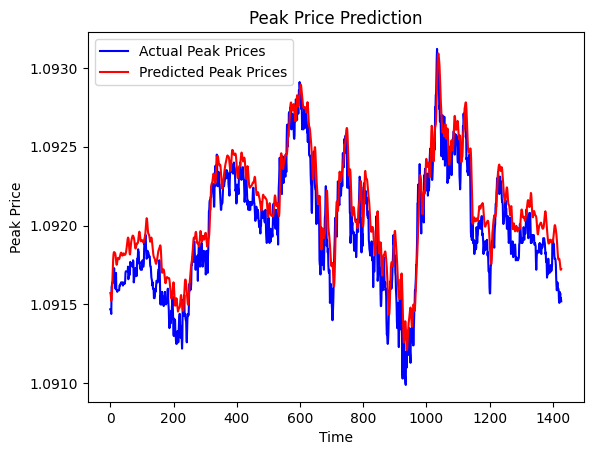

In [4]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Peak Prices')
plt.plot(predicted_prices_rescaled, color='red', label='Predicted Peak Prices')
plt.title('Peak Price Prediction')
plt.xlabel('Time')
plt.ylabel('Peak Price')
plt.legend()
plt.show()


In [5]:
model.save('../models/aug-week6.h5')